Docs prep....
Vectorize...
Vectorization done
(25000, 250)
(25000, 250)
SimpleNN (
  (ln0): Linear (250 -> 15)
  (ln4): Linear (15 -> 2)
  (sigmoid): Sigmoid ()
)
Runnning Epochs...
Epoch 0 loss 0.6930392980575562
Epoch 10 loss 0.5812946557998657
Epoch 20 loss 0.5426656007766724
Epoch 30 loss 0.5271279811859131
Epoch 40 loss 0.5186803340911865
Epoch 50 loss 0.5134040117263794
Epoch 60 loss 0.509756863117218
Epoch 70 loss 0.5070639848709106
Epoch 80 loss 0.504982590675354
Epoch 90 loss 0.5033174157142639
Epoch 100 loss 0.5019596219062805
Epoch 110 loss 0.5008281469345093
Epoch 120 loss 0.49986305832862854
Epoch 130 loss 0.4990273416042328
Epoch 140 loss 0.4982919692993164
Epoch 150 loss 0.4976387917995453
Epoch 160 loss 0.4970616102218628
Epoch 170 loss 0.4965473413467407
Epoch 180 loss 0.49608442187309265
Epoch 190 loss 0.49566665291786194
accuracy 0.805


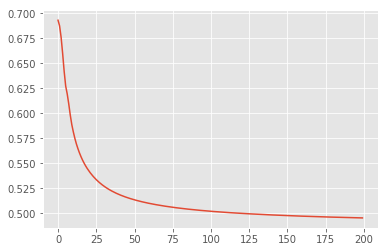

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
style.use('ggplot')
my_word = ENGLISH_STOP_WORDS - {'not','didnt'}

POS_TRAIN_PATH = '../Pytorch//data/aclImdb/train/pos/'
NEG_TRAIN_PATH = '../Pytorch//data/aclImdb/train/neg/'
pos_files = os.listdir(POS_TRAIN_PATH)
neg_files = os.listdir(NEG_TRAIN_PATH)
print('Docs prep....')

pos_lines = []
neg_lines = []
for file in pos_files:
    with open(POS_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        pos_lines.extend(lines)
for file in neg_files:
    with open(NEG_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        neg_lines.extend(lines)

docs = []
docs.extend(pos_lines)
docs.extend(neg_lines)
print('Vectorize...')
vectorizer2 = TfidfVectorizer(stop_words=my_word, max_features=250)
vectorizer2.fit(docs)
print('Vectorization done')

input_data2 = vectorizer2.transform(docs).todense()
print(input_data2.shape)
df2 = pd.DataFrame(input_data2)

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

labels2 = []
labels2 = np.append(pos_labels, neg_labels)
df2['labels'] = labels2
# df2.to_csv('data/aclImdb/processed_input_labelled3.csv')

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

X = df2.drop('labels', axis=1)
X = np.array(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, df2['labels'], random_state=20)


class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.ln0 = nn.Linear(input_size, 15)
        self.ln1 = nn.Linear(15, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output = F.relu(self.ln0(x))
        output = self.sigmoid(self.ln1(output))
        return output

net = SimpleNN(X_train.shape[1], 2)
print(net)
print('Runnning Epochs...')

epochs = 200
learning_rate = 5e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate)
losses = []
for epoch in range(epochs):
    inputs = Variable(torch.from_numpy(np.array(X_train).astype(np.float32)))
    targets = Variable(torch.from_numpy(np.array(y_train).astype(np.float32)).long())
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch %d loss %s' % (epoch, loss.data[0]))
    losses.append(loss.data[0])

total = len(X_test)
correct = 0.0
net.eval()
for val_x, val_y in zip(X_test, y_test):
    #     index = 0
    #     target = y_test[index]

    t_x = np.array(val_x).astype(np.float32)
    output = net(Variable(torch.from_numpy(np.array([t_x]))))[0]
    # print(output)
    out = output.data.numpy()
    if val_y == 0:
        # print('actual: Positive')
        if not np.argmax(out):
            correct += 1
            # print('predicted: Positive')
        # else:
            # print('predicted: Negative')

    if val_y == 1:
        # print('actual: Negative')
        if np.argmax(out):
            correct += 1
            # print('predicted: Negative')
        # else:
            # print('predicted: Positive')


print('accuracy %.3f' % (correct / total))
plt.plot(losses)
plt.show()

